<a href="https://www.kaggle.com/toygarr/yemeksepeti-sentiment-analysis?scriptVersionId=82999076" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# *I hope this notebook will give you an intuition about data handling by purpose and creating different type of training models* 

* I tried to keep it as simple as possible. Have a nice ml day.

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# nltk
import nltk
from nltk.corpus import stopwords

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

2021-12-22 10:32:44.723967: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-22 10:32:44.724108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
nltk.download('stopwords')
!pip install TurkishStemmer
from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Settings

In [4]:
TEST_SIZE = 0.1

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 16
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 256

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLD = (0.65)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

## Read Dataset

### Dataset details
* **target**: the polarity of the tweet (1-5 = negative, 6-10 = positive) -> custom feature, we created target feature to be able to make binary classification
* **speed**: speed point
* **service**: service point
* **flavour**: flavour point
* **review**: the text of the comments (Superdi.)

In [5]:
df= pd.read_csv("../input/yorumsepeti/yorumsepeti.csv", sep=';')

In [6]:
print("Dataset size:", len(df))

Dataset size: 60242


In [7]:
df.head(5)

,speed,service,flavour,review
0,-,1,1,Her zaman komşu fırından sipariş verdiğim için...
1,-,10,2,sosisli ürün isteyen adama peynirli bişey yol...
2,-,10,10,Siparisimi cok hizli getiren ekip arkadasiniza...
3,1,1,7,"After waiting more tjan one hour, they didnt d..."
4,4,4,1,Iyi pişsin diye söylememe rağmen az pişmiş gel...


In [8]:
df['Character Count'] = df['review'].apply(lambda x: len(str(x)))
df['Character Count'].max(axis = 0, skipna = True)

310

In [9]:
pd.isna(df['review']).sum()

33

# Pre-Process dataset

In [10]:
df = df.dropna(subset=['review'], axis=0)

In [11]:
# We will use the mean of 3 point scoring system
# so we will change the dataset to target-text

df['speed'] = df['speed'].replace(['-'], np.nan)
df['service'] = df['service'].replace(['-'], np.nan)
df['flavour'] = df['flavour'].replace(['-'], np.nan)

df['speed'] = df['speed'].astype(float)
df['service'] = df['service'].astype(float)
df['flavour'] = df['flavour'].astype(float)
df['review'] = df['review'].astype(str)


## Creating a target column to be able to make binary classification depending on mean of 3 types of scoring

In [12]:
df = df.assign(target=df.loc[:, ['speed', 'service', 'flavour']].mean(axis=1))
df['target'] = round(df['target'])

df = df.dropna(subset=['target'], axis=0)
df['target'] = df['target'].astype(int)

df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,Her zaman komşu fırından sipariş verdiğim için...,202,1
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yol...,135,6
2,NaN,10.0,10.0,Siparisimi cok hizli getiren ekip arkadasiniza...,63,10
3,1.0,1.0,7.0,"After waiting more tjan one hour, they didnt d...",85,3
4,4.0,4.0,1.0,Iyi pişsin diye söylememe rağmen az pişmiş gel...,73,3
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,Super.,6,10
60238,10.0,10.0,10.0,Mükemmelsiniz.,14,10
60239,10.0,10.0,10.0,Çorbası efsane mutlaka deneyin.,31,10
60240,10.0,10.0,10.0,Harikasınız!,12,10


### Recap: We have mean scores in target column. We map it as, 1-5 points correspond to negative, 6-10 points correspond to positive. We will use 0.65 as threshold

In [13]:
decode_map = { 1:"NEGATIVE", 2:"NEGATIVE" ,3: "NEGATIVE", 4:"NEGATIVE", 5:"NEGATIVE",6: "POSITIVE",
              7: "POSITIVE", 8: "POSITIVE", 9: "POSITIVE", 10: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [14]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 30.8 ms, sys: 76 µs, total: 30.9 ms
Wall time: 30.7 ms


In [15]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,Her zaman komşu fırından sipariş verdiğim için...,202,NEGATIVE
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yol...,135,POSITIVE
2,NaN,10.0,10.0,Siparisimi cok hizli getiren ekip arkadasiniza...,63,POSITIVE
3,1.0,1.0,7.0,"After waiting more tjan one hour, they didnt d...",85,NEGATIVE
4,4.0,4.0,1.0,Iyi pişsin diye söylememe rağmen az pişmiş gel...,73,NEGATIVE
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,Super.,6,POSITIVE
60238,10.0,10.0,10.0,Mükemmelsiniz.,14,POSITIVE
60239,10.0,10.0,10.0,Çorbası efsane mutlaka deneyin.,31,POSITIVE
60240,10.0,10.0,10.0,Harikasınız!,12,POSITIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

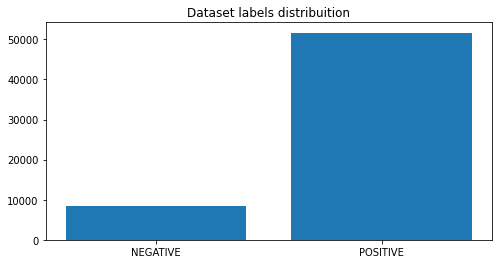

In [16]:
target_cnt = Counter(df.target)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [17]:
stop_words = stopwords.words("turkish")

In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
df.review = df.review.apply(lambda x: preprocess(x))

CPU times: user 1.59 s, sys: 14.3 ms, total: 1.6 s
Wall time: 1.6 s


In [20]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,zaman komşu fırından sipariş verdiğim eksik gö...,202,NEGATIVE
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yoll...,135,POSITIVE
2,NaN,10.0,10.0,siparisimi cok hizli getiren ekip arkadasiniza...,63,POSITIVE
3,1.0,1.0,7.0,after waiting more tjan one hour they didnt de...,85,NEGATIVE
4,4.0,4.0,1.0,iyi pişsin söylememe rağmen pişmiş geldi birda...,73,NEGATIVE
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,super,6,POSITIVE
60238,10.0,10.0,10.0,mükemmelsiniz,14,POSITIVE
60239,10.0,10.0,10.0,çorbası efsane mutlaka deneyin,31,POSITIVE
60240,10.0,10.0,10.0,harikasınız,12,POSITIVE


## Split train and test

In [21]:
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 54185
TEST size: 6021


## Word2Vec 

In [22]:
%%time
documents = [_text.split() for _text in df_train.review] 

CPU times: user 109 ms, sys: 42.2 ms, total: 151 ms
Wall time: 150 ms


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [24]:
w2v_model.build_vocab(documents)

In [25]:
vocab_len = len(w2v_model.wv)
print("Vocab size", vocab_len)

Vocab size 4775


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 33.6 s, sys: 252 ms, total: 33.9 s
Wall time: 10.9 s


(5896384, 8096368)

In [27]:
w2v_model.wv.most_similar("tatlı")

[('hediye', 0.7106674313545227),
 ('puding', 0.6944542527198792),
 ('kurabiye', 0.6708093285560608),
 ('göndermeleri', 0.6372334957122803),
 ('gönderdiğiniz', 0.6367180347442627),
 ('gönderdikleri', 0.6366036534309387),
 ('tatlıyı', 0.6255597472190857),
 ('ikramı', 0.6250806450843811),
 ('notunuz', 0.6154495477676392),
 ('tatlılar', 0.6126114130020142)]

In [28]:
all_sims = w2v_model.wv.most_similar(negative="tatlı")
all_sims

[('lahmacunlar', 0.3868674635887146),
 ('tadını', 0.37176716327667236),
 ('ekmekler', 0.37020647525787354),
 ('yağlı', 0.3662490248680115),
 ('ürünler', 0.35433825850486755),
 ('şekli', 0.35379138588905334),
 ('yavaş', 0.3531617224216461),
 ('hemde', 0.35173681378364563),
 ('olmuştu', 0.3513964116573334),
 ('yemeğin', 0.3480992317199707)]

## Tokenize Text

In [29]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 46043
CPU times: user 1.66 s, sys: 229 ms, total: 1.89 s
Wall time: 1.59 s


In [30]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.review), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.04 s, sys: 69.7 ms, total: 2.11 s
Wall time: 2.11 s


In [31]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [32]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (54185, 300)
y_train (54185, 1)

x_test (6021, 300)
y_test (6021, 1)


____________________________________

# Imbalanced distribution handling

In [33]:
from imblearn.over_sampling import SMOTE

def smote(x, y):
    smote = SMOTE(sampling_strategy= 1, random_state=42)
    x, y = smote.fit_resample(x, y)
    return x, y

In [34]:
print(x_train.shape)
print(y_train.shape)

(54185, 300)
(54185, 1)


In [35]:
# CREATING DICTIONARY TO SEE CLASS DIST
df_c = pd.DataFrame(y_train)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{1: 46502, 0: 7683}

In [36]:
x_train, y_train = smote(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(93004, 300)
(93004,)


In [37]:
## CONTROL THE AUGMENTED DISTRIBUTION
df_c = pd.DataFrame(y_train)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{0: 46502, 1: 46502}

## Embedding layer

In [38]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(46043, 300)


# Build Model

In [39]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                                            input_length=SEQUENCE_LENGTH, trainable=False)

sequence_input = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = tf.keras.layers.SpatialDropout1D(0.2)(embedding_sequences)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.summary()

2021-12-22 10:33:43.262257: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-22 10:33:43.265651: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-22 10:33:43.265699: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 10:33:43.265734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6cfadf9eb844): /proc/driver/nvidia/version does not exist
2021-12-22 10:33:43.266149: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          13812900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 64)           57664     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0     

## Compile model

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Callbacks

In [41]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# Train

In [47]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=3,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/3
327/327 [==============================] - 571s 2s/step - loss: 0.3069 - accuracy: 0.8635 - val_loss: 0.2027 - val_accuracy: 0.9178
Epoch 2/3
327/327 [==============================] - 560s 2s/step - loss: 0.2430 - accuracy: 0.8936 - val_loss: 0.1637 - val_accuracy: 0.9314
Epoch 3/3
327/327 [==============================] - 563s 2s/step - loss: 0.2213 - accuracy: 0.9034 - val_loss: 0.1653 - val_accuracy: 0.9345
CPU times: user 1h 41min 21s, sys: 5min 29s, total: 1h 46min 51s
Wall time: 28min 13s


# Evaluate

In [48]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

24/24 [==============================] - 7s 288ms/step - loss: 0.2379 - accuracy: 0.8877

ACCURACY: 0.8877263069152832
LOSS: 0.23787398636341095
CPU times: user 24.3 s, sys: 1.87 s, total: 26.2 s
Wall time: 6.98 s


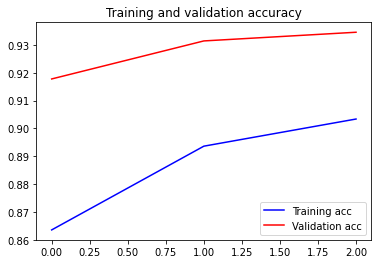

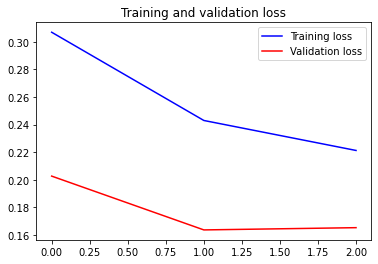

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [50]:
def decode_sentiment(score):
    if score <= SENTIMENT_THRESHOLD:
        label = NEGATIVE
    else:
        label = POSITIVE

    return label

In [51]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [52]:
predict("Lütfen şu yemeği düzgün pişirin")

{'label': 'NEGATIVE',
 'score': 0.4847169518470764,
 'elapsed_time': 0.5738275051116943}

In [53]:
predict("İşini aşkla yapan bir mekan daha sarrrrdı")

{'label': 'POSITIVE',
 'score': 0.9860054850578308,
 'elapsed_time': 0.08130526542663574}

In [54]:
predict("Kuryeniz çok saygısız")

{'label': 'NEGATIVE',
 'score': 0.6488816142082214,
 'elapsed_time': 0.09316873550415039}

In [55]:
predict("lezzet sıfır kalite sıfır hizmet sıfır ekmek arası ekmek de göndermezsiniz.")

{'label': 'NEGATIVE',
 'score': 0.05455026030540466,
 'elapsed_time': 0.1322920322418213}

In [56]:
predict("EFFFFSANEYDİ BEEE")

{'label': 'POSITIVE',
 'score': 0.890700101852417,
 'elapsed_time': 0.1051340103149414}

In [57]:
predict("Ellerinize sağlık çok güzeldi")

{'label': 'POSITIVE',
 'score': 0.9998509883880615,
 'elapsed_time': 0.09023475646972656}

In [58]:
predict("Bi tantuni yiyelim dedik kusacaktık reziller sizi")

{'label': 'NEGATIVE',
 'score': 0.6103951930999756,
 'elapsed_time': 0.09607291221618652}

In [59]:
predict("Hep buradan alıyoruz yine memnunuz teşekkürler")

{'label': 'POSITIVE',
 'score': 0.9977142810821533,
 'elapsed_time': 0.11345267295837402}

In [60]:
predict("bir daha burdan almayın paranıza yazık")

{'label': 'NEGATIVE',
 'score': 0.1610947549343109,
 'elapsed_time': 0.11508297920227051}

In [70]:
predict("Bugün günlerden açlık günü zannetmiştim ama varya biliyosunuz bu işi.")

{'label': 'POSITIVE',
 'score': 0.8463954329490662,
 'elapsed_time': 0.09583210945129395}

## Confusion Matrix

In [62]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

2021-12-22 11:03:58.551195: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2167560000 exceeds 10% of free system memory.


1/1 [==============================] - 9s 9s/step
CPU times: user 24.2 s, sys: 9.46 s, total: 33.7 s
Wall time: 9.16 s


In [63]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

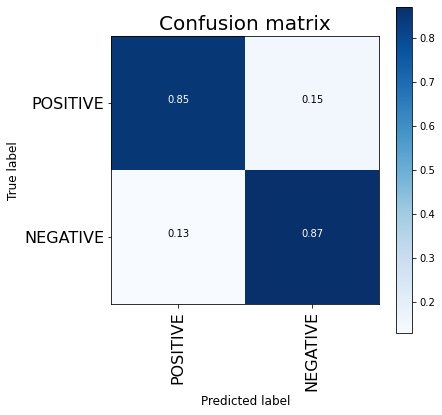

CPU times: user 484 ms, sys: 164 ms, total: 648 ms
Wall time: 417 ms


In [64]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

## Classification Report

In [65]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.53      0.85      0.65       867
    POSITIVE       0.97      0.87      0.92      5154

    accuracy                           0.87      6021
   macro avg       0.75      0.86      0.78      6021
weighted avg       0.91      0.87      0.88      6021



## Accuracy Score

In [71]:
accuracy_score(y_test_1d, y_pred_1d)

0.8681282179040026

# Save model

In [67]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

_________

Fetching data from twitter
To get started, we’ll need to do the following things:

* Set up a Twitter account if you don’t have one already.
* Using the Twitter dev account, we will need to apply for Developer Access and then create an application that will generate the API credentials that you will use to access Twitter from Python.
* Import the tweepy package.

## Authorization
After installing and importing tweepy package (already done in the beginning), to access the Twitter API, we will need 4 things 
from the your Twitter App page. These keys are located in our Twitter app settings in the Keys and Access Tokens tab.
> consumer key <br />
consumer seceret key<br />
access token key<br />
access token secret key

In [ ]:
!pip install tweepy
!pip install streamlit

In [ ]:
import tweepy as tw #for accessing Twitter API
#Getting authorization
consumer_key= "X"
consumer_key_secret= "X"
access_token= "X"
access_token_secret= "X"

auth = tw.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

## Search Twitter for Tweets
### 1. Searching for a hashtag from a specified date
Now we are ready to search Twitter for recent tweets! We will use the **.Cursor** method to get an object containing tweets containing the hashtag #yemeksepeti. 

To create this query, we will define the:

* Search term - in this case #yemeksepeti
* the start date of our search

In [ ]:
# Define the search term and the date_since date as variables
search_words = "#yemeksepeti"
date_since = "2021-12-20"

We can restrict the number of tweets returned by specifying a number in the .items() method. .items(10) will return 10 of the most recent tweets.

In [ ]:
# Collect tweets
tweets = tw.Cursor(api.search_tweets,
              q=search_words,
              lang="tr",
              since=date_since).items(10)

# Iterate and print tweets
for tweet in tweets:
    print(tweet.text)
    predict([tweet.text]) #predicting sentiment
    print("")

## 2. Searching for a keyword
We can pass the keyword of  interest here and the number of tweets (in this case 10) to be downloaded through the tweepy API.

In [ ]:
for tweet in api.search_tweets(q="elonmusk", lang="tr", rpp=10):
    print(f"{tweet.user.name}:{tweet.text}")
    predict([tweet.text]) #predicting sentiment
    print("")

## 3. Searching for a username
The user_timeline() method of the API class in Tweepy module is used to get the most recent statuses posted from the authenticating user or the user specified.

* screen_name = user id name of the twitter user
* count = no. of tweets to be fetched
* lang = language of tweet
* tweet_mode = 'extended' swaps the text index for full_text, and prevents a primary tweet longer than 140 characters from being truncated. <br />

The below query pulls 10 tweets from Twitter user @ of english language and predicts its sentiments.

In [ ]:
posts = api.user_timeline(screen_name="elonmusk", count = 10, lang ="tr", tweet_mode="extended")

l=[] 
i=1

for tweet in posts[:10]:
    l.append(tweet.full_text) 
    i=i+1
for j in range (0,9):
    print(l[j])
    predict([l[j]])  #predicting sentiment
    print("\n")